In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore') 

2023-04-16 18:29:38.707395: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 18:29:39.523987: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 18:29:39.551713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 18:29:48.731381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Fetching data and Do EDA 
### Decide about flow

In [3]:
image_path = "/mnt/home/patelk69/first_try/data/Images"
caption_path = "/mnt/home/patelk69/first_try/data/captions/captions.txt"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mlpimg

In [5]:
# read text file 
caption =  pd.read_csv(caption_path)
caption

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
6349,2226587791_66e29dd01d.jpg,"Baby in water , held by hands of person out of..."
6350,222759342_98294380fc.jpg,A child stoops to pick up a watermelon from a ...
6351,222759342_98294380fc.jpg,A little girl picking up a watermelon from a p...
6352,222759342_98294380fc.jpg,A small girl dressed in a yellow dress with fl...


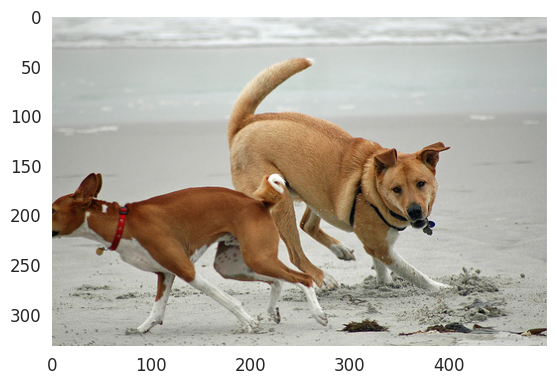

caption : Two different breeds of brown and white dogs play on the beach .
caption : Two dogs are making a turn on a soft sand beach .
caption : Two dogs playing in the sand at the beach .
caption : Two dogs playing together on a beach .
caption : Two large tan dogs play along a sandy beach .


In [6]:
## data visulization

temp_img_path = image_path +"/"+ caption.iloc[101,0]
image = mlpimg.imread(temp_img_path)

plt.imshow(image)
plt.show()

for i in range(100,100+5):
    print("caption :",caption.iloc[i,1])

Dictionary to Map each image with the list of captions it has



In [7]:
discription = {}

for x in range(len(caption)):
    id = caption.iloc[x,0]
    cap = caption.iloc[x,1]
    if id not in discription:
        discription[id] = []
    discription[id].append(cap)


In [8]:
discription

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

In [9]:
discription["1000268201_693b08cb0e.jpg"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## cleaning the data

👉 In this step we are buliding the fuction to clean the text data. As we can see that in the above output, there are things like the `full-stop` as well as  `a`, `an`, `the` is not usefull so we need to remove them before passing into the model.

### Caption Text Preprocessing Steps
* Convert sentences into lowercase
* Remove special characters and numbers present in the text
* Remove extra spaces
* Remove single characters
* Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence


In [10]:
#creating the dataframe which only contains captions
captions = caption['caption']


In [11]:
def text_clean(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

text_clean(caption)

,image,caption
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into ...
...,...,...
6349,2226587791_66e29dd01d.jpg,startseq baby in water held by hands of person...
6350,222759342_98294380fc.jpg,startseq child stoops to pick up watermelon fr...
6351,222759342_98294380fc.jpg,startseq little girl picking up watermelon fro...
6352,222759342_98294380fc.jpg,startseq small girl dressed in yellow dress wi...


In [12]:
# regenerating the dictionary 
discription = {}

for x in range(len(caption)):
    id = caption.iloc[x,0]
    cap = caption.iloc[x,1]
    if id not in discription:
        discription[id] = []
    discription[id].append(cap)


In [13]:
discription

{'1000268201_693b08cb0e.jpg': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70.jpg': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tri-colored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8.jpg': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted 

### Tokanization and Encoding the sentence data

In [14]:
sentences = text_clean(caption)
captions = captions.tolist()
captions

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .',
 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails pain

In [15]:
tokenizer  = Tokenizer()


In [16]:
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index)+1

max_length = max(len(cap.split()) for cap in captions)
print("max_length of string input : ", max_length)

images = caption['image'].unique().tolist()
no_image = len(images)
print("number of data images : ",no_image)

max_length of string input :  35
number of data images :  1271


In [17]:
image_present = os.listdir(image_path)
len(image_present)

8091

In [18]:
caption = caption[caption['image'].isin(image_present)]
no_image = len(caption)

In [19]:
#spliting the data into train and velidations
images = caption['image'].unique().tolist()

split_id = round(0.85*no_image)
train_images = images[:split_id]
val_images = images[split_id:]

train = caption[caption['image'].isin(train_images)]
validation = caption[caption['image'].isin(val_images)]


In [42]:
train.reset_index(inplace=True,drop=True)
validation.reset_index(inplace=True,drop=True)

# Model Building

## Image Feature Extraction

In [20]:
model = DenseNet201()

In [21]:
ip = model.input
op = model.layers[-2].output
fe = tf.keras.Model(inputs=ip,outputs = op)

In [22]:
images[43]

'1056359656_662cee0814.jpg'

In [23]:
img_size = 224
features = {}
for image in tqdm(images):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 1271/1271 [04:07<00:00,  5.14it/s]


## data creation for model

In [29]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y

    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


## model building

here i have taken the help from kaggle as i am learning how to build the Deep-learning model

In [30]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)


caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

2023-04-16 18:36:36.343958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 18:36:36.345765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 18:36:36.347008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(caption_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [32]:
caption_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          491776      ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 256)       0           ['dense_3[0][0]']                
                                                                                            

In [34]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=validation,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

model_name = "base_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)


earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [ ]:
model_name = "base_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)


earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 2, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [36]:
history = caption_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        )

Epoch 1/10


2023-04-16 18:49:09.111118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-16 18:49:09.485780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 18:49:09.487843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

99/99 [==============================] - 284s 3s/step - loss: 6.3357
Epoch 2/10
99/99 [==============================] - 65s 657ms/step - loss: 5.5717
Epoch 3/10
99/99 [==============================] - 67s 680ms/step - loss: 5.0308
Epoch 4/10
99/99 [==============================] - 60s 608ms/step - loss: 4.6637
Epoch 5/10
99/99 [==============================] - 52s 525ms/step - loss: 4.4117
Epoch 6/10
99/99 [==============================] - 54s 540ms/step - loss: 4.2119
Epoch 7/10
99/99 [==============================] - 52s 522ms/step - loss: 4.0335
Epoch 8/10
99/99 [==============================] - 55s 554ms/step - loss: 3.8930
Epoch 9/10
99/99 [==============================] - 52s 523ms/step - loss: 3.7522
Epoch 10/10
99/99 [==============================] - 56s 565ms/step - loss: 3.6329


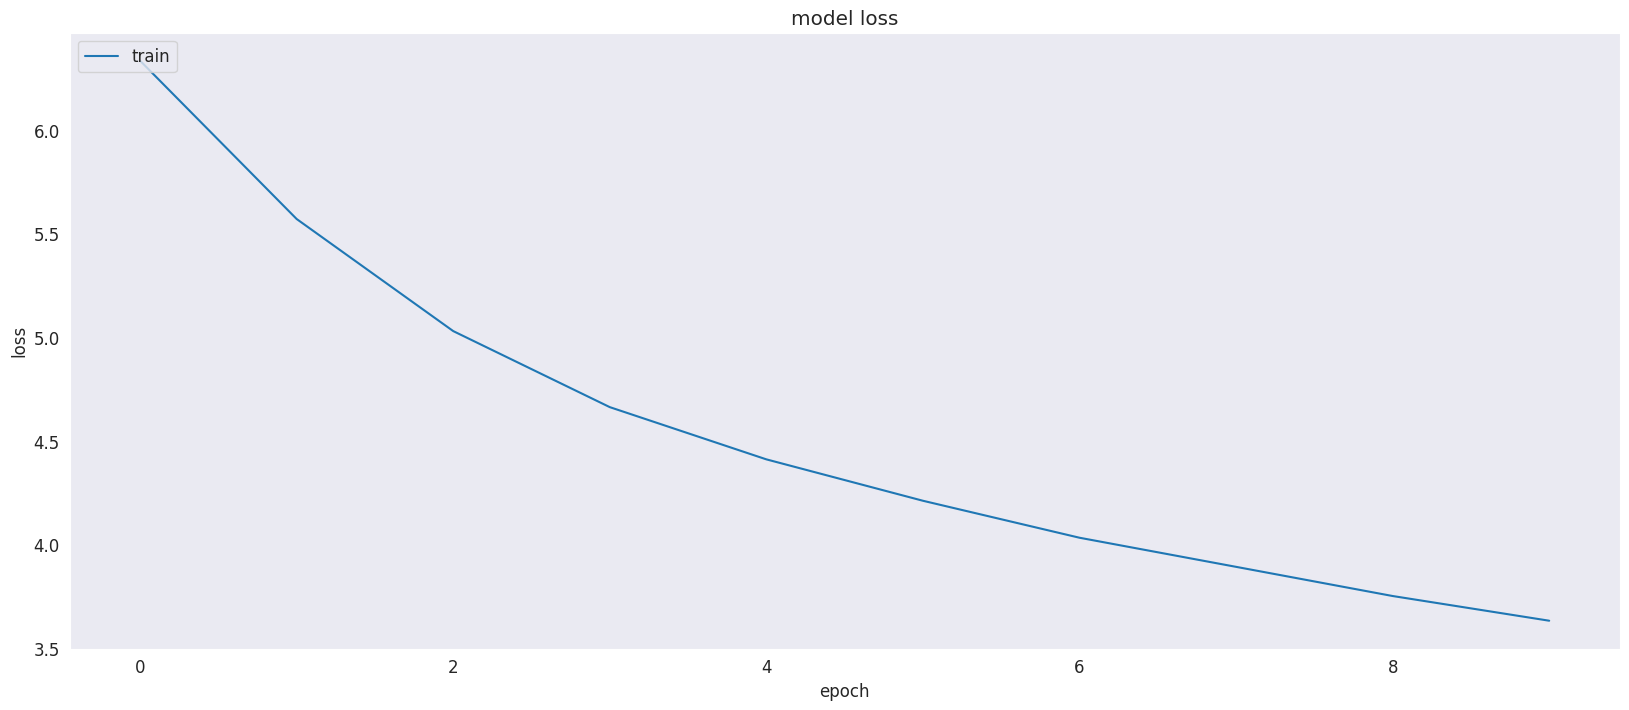

In [38]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [40]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        if word == 'endseq':
            break
            
    return in_text

In [54]:
samples = train[100:115]
samples.reset_index(drop=True,inplace=True)

In [55]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

2023-04-16 19:19:49.226508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 19:19:49.228638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 19:19:49.230060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 25ms/step


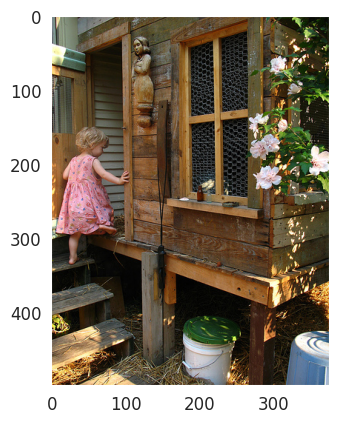

1/1 [==============================] - 0s 24ms/step
startseq is sitting on the train bench in the street in front of the street in front of the building in front of the building of building in the street and an outdoor an outdoor outdoor


In [65]:
temp_img_path = image_path +"/"+ '1000268201_693b08cb0e.jpg'
image = mlpimg.imread(temp_img_path)

plt.imshow(image)
plt.show()


pred = predict_caption(caption_model, '1000268201_693b08cb0e.jpg', tokenizer, max_length, features)
print(pred)

In [62]:
caption_model.save("/mnt/home/patelk69/first_try/base_model")

2023-04-16 19:31:02.500064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 19:31:02.501929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 19:31:02.503411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: /mnt/home/patelk69/first_try/base_model/assets


INFO:tensorflow:Assets written to: /mnt/home/patelk69/first_try/base_model/assets
